In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

In [64]:
print(sys.version)
print(torch.__version__)

3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
2.1.0+cu121


In [65]:
class PlayingCardDataset(Dataset):
    
    def __init__(self, data_dir,transform=None):

        self.data = ImageFolder(data_dir,transform=transform)

    

    def __len__(self):

        return len(self.data)
    

    def __getitem__(self,idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [66]:
dataset = PlayingCardDataset(data_dir='D:\\vscode\\Pistachio Image Dataset\\output\\train')
len(dataset)

1717

In [67]:
dataset[9]

(<PIL.Image.Image image mode=RGB size=600x600>, 0)

1


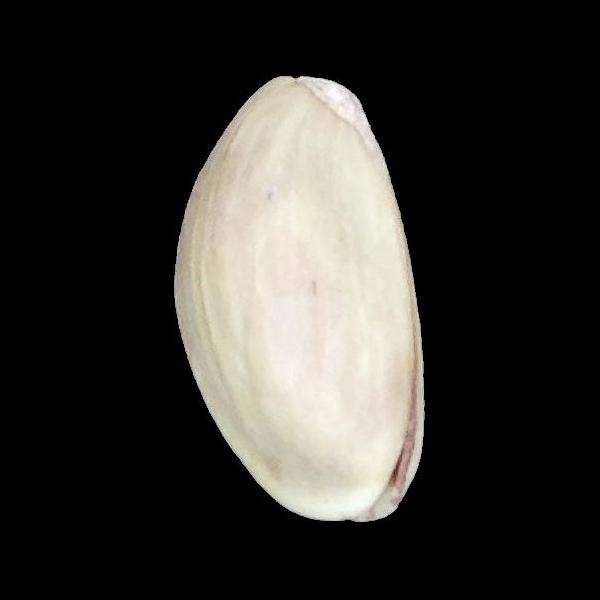

In [68]:
image, label =dataset[1000]
print(label)
image

In [69]:
data_dir = 'D:\\vscode\\Pistachio Image Dataset\\output\\train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'Kirmizi_Pistachio', 1: 'Siirt_Pistachio'}


In [70]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

data_dir = 'D:\\vscode\\Pistachio Image Dataset\\output\\train'
dataset = PlayingCardDataset(data_dir, transform)

In [71]:
dataset[100]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [72]:
dataloder=DataLoader(dataset,batch_size=32,shuffle=True)

In [73]:
for images,label in dataloder:
    break

In [74]:
images.shape

torch.Size([32, 3, 224, 224])

In [75]:
label

tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0])

In [76]:
class SimpleCardClassifier(nn.Module):
    
    def __init__(self,num_classes=2):
        super(SimpleCardClassifier,self).__init__()
        self.base_model = timm.create_model('efficientnet_b0',pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.classifier = nn.Linear(enet_out_size,num_classes)
    
    def forward(self,x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [77]:
model = SimpleCardClassifier(num_classes=2)

In [78]:
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [79]:
example_out=model(images)
example_out.shape

torch.Size([32, 2])

In [80]:
# Loss Functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [81]:
criterion(example_out,label)

tensor(0.7067, grad_fn=<NllLossBackward0>)

In [82]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = 'D:\\vscode\\Pistachio Image Dataset\\output\\train'
valid_folder = 'D:\\vscode\\Pistachio Image Dataset\\output\\val'
test_folder = 'D:\\vscode\\Pistachio Image Dataset\\output\\test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [83]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifier(num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Validation loop: 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


Epoch 1/5 - Train loss: 0.20772508303561596, Validation loss: 0.1953618838408283


Validation loop: 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


Epoch 2/5 - Train loss: 0.0942001606993503, Validation loss: 0.7632292495457299


Validation loop: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]


Epoch 3/5 - Train loss: 0.08109347673700379, Validation loss: 0.33747954199484453


Validation loop: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


Epoch 4/5 - Train loss: 0.06305776914417847, Validation loss: 0.1707749821106407


Validation loop: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

Epoch 5/5 - Train loss: 0.03503871325297139, Validation loss: 0.06985559944764093


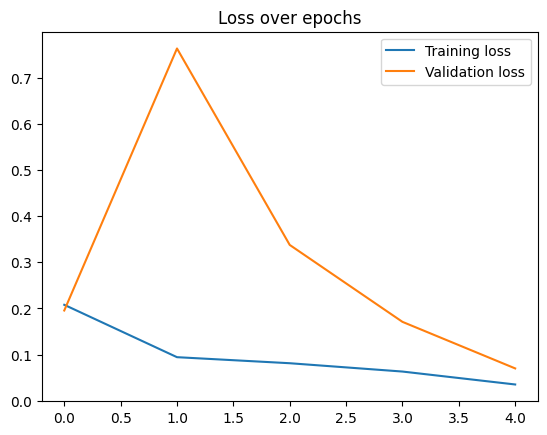

In [85]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()
